In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm

In [6]:
plot_step = 0.05
width = 3
n = 1000
acc_thresh = 0.92
epochs = 100

In [7]:
def generate_gaussian_parity(n):
    means = [[-1, -1], [-1, 1], [1, 1], [1, -1]]    
    X = np.array([[np.random.uniform(-1, 1), np.random.uniform(-1, 1)] for _ in range(n)])
    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

    random_indices_order = list(range(len(X)))
    np.random.shuffle(random_indices_order)
    return X[random_indices_order], np.array(y[random_indices_order]).astype('int')

In [8]:
X, y = generate_gaussian_parity(n = n)

1 Hidden Layer

In [9]:
acc = 0
while acc < acc_thresh:
  print("Starting New Network")
  network = keras.Sequential()
  network.add(keras.layers.Dense(width, input_shape = np.shape(X)[1:], activation = 'relu', use_bias=False, kernel_initializer = 'he_normal'))
  network.add(keras.layers.Dense(1, activation = 'sigmoid', use_bias=False, kernel_initializer = 'he_normal'))

  network.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(lr = 1e-2, momentum = 0.9), metrics = ['acc'])
  network.fit(X, 
              y, 
              epochs = epochs, 
              verbose = False,
              callbacks = keras.callbacks.EarlyStopping(monitor="loss", patience = 5, min_delta = .008)
              )

  acc = network.evaluate(X, y, verbose = False)[1]

Starting New Network
Starting New Network
Starting New Network
Starting New Network
Starting New Network


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


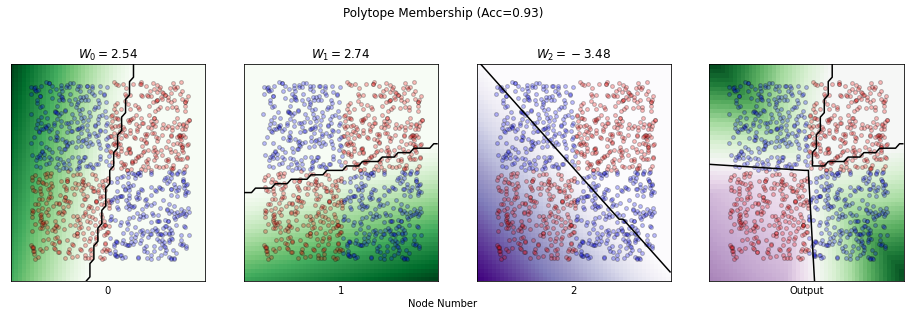

In [10]:
figs, axs = plt.subplots(1, width + 1, figsize = (4 * (width + 1), 4))
figs.text(0.5, 0.04, 'Node Number', ha='center')

for i, ax in enumerate(axs.flat):
  ax.set(xlabel=i)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.label_outer()

figs.suptitle("Polytope Membership (Acc={:0.2f})".format(acc), y=1.08)

encoder = keras.models.Model(network.inputs, network.layers[-2].output)

x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

#w, b = network.layers[-1].get_weights()
w = network.layers[-1].get_weights()[0]

penultimate_activations = encoder.predict(np.c_[xx.ravel(), yy.ravel()])
for node in range(width):
  polytope_membership = penultimate_activations[:, node].reshape(xx.shape)
  penultimate_heatmap = axs[node].pcolormesh(xx, yy, polytope_membership, cmap="Greens" if w[node] > 0 else "Purples")
  axs[node].contour(xx, yy, polytope_membership, levels=[0], cmap="Greys_r")
  axs[node].set_title(r"$W_{}={:0.2f}$".format(node, float(w[node])))
    
final_polytope = (np.matmul(penultimate_activations, w)).reshape(xx.shape)

v = max(abs(np.min(final_polytope)), abs(np.max(final_polytope)))

final_heatmap = axs[width].pcolormesh(xx, 
                                      yy, 
                                      final_polytope, 
                                      cmap="PRGn", 
                                      vmin = -v, 
                                      vmax = v)

#epsilon = 2e-1 * int(1 if b < 0 else -1)
#axs[width].contour(xx, yy, final_polytope + epsilon, levels=[0], cmap="Greys_r")
axs[width].contour(xx, yy, final_polytope, levels=[0], cmap="Greys_r")
axs[width].set(xlabel = "Output")
#axs[width].set_title(r"$B={:0.2f}$".format(float(b)))

# Plot the training points
for y_val in range(2):
  idx = np.where(y == y_val)
  for node in range(width + 1):
    axs[node].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
                cmap="Reds", s=15, alpha = 0.25, edgecolor = 'black')

2 Hidden Layers

In [11]:
acc = 0
while acc < acc_thresh:
  print("Starting New Network")
  network = keras.Sequential()
  network.add(keras.layers.Dense(width, input_shape = np.shape(X)[1:], activation = 'relu', use_bias=False, kernel_initializer = 'he_normal'))
  network.add(keras.layers.Dense(width, activation = 'relu', use_bias=False, kernel_initializer = 'he_normal'))
  network.add(keras.layers.Dense(1, activation = 'sigmoid', use_bias=False, kernel_initializer = 'he_normal'))

  network.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(1e-2, momentum = 0.9), metrics = ['acc'])
  network.fit(
      X, 
      y, 
      epochs = epochs, 
      verbose = False,
      callbacks = keras.callbacks.EarlyStopping(monitor="acc", patience = 5, min_delta = .008)
  )

  acc = network.evaluate(X, y, verbose = False)[1]

Starting New Network


In [12]:
ultimate_weights = np.array(network.layers[-1].get_weights()[0])
#ultimate_bias = np.array(network.layers[-1].get_weights()[1])

ws = np.array([network.layers[i].get_weights()[0] for i in {0, 1}])
#bs = [network.layers[i].get_weights()[1] for i in {0, 1}]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: No contour levels were found within the data range.


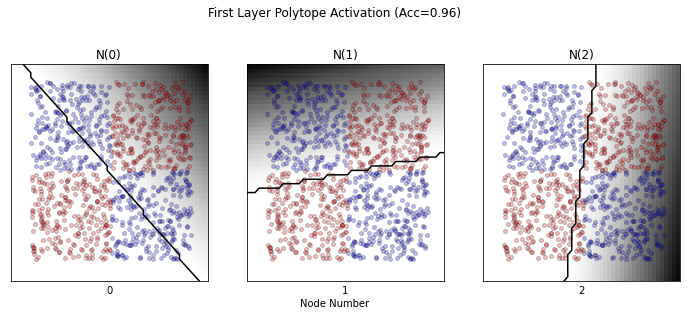

In [13]:
figs, axs = plt.subplots(1, width, figsize = (4 * (width), 4))
figs.text(0.5, 0.04, 'Node Number', ha='center')

for i, ax in enumerate(axs.flat):
  ax.set(xlabel=i)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.label_outer()

figs.suptitle("First Layer Polytope Activation (Acc={:0.2f})".format(acc), y=1.08)

encoder = keras.models.Model(network.inputs, network.layers[0].output)

x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

second_layer_activations = encoder.predict(np.c_[xx.ravel(), yy.ravel()])
for second_node in range(width):
  polytope_membership = second_layer_activations[:, second_node].reshape(xx.shape)
  v = max(abs(np.min(polytope_membership)), abs(np.max(polytope_membership)))
  axs[second_node].pcolormesh(xx, 
                              yy, 
                              polytope_membership, 
                              cmap="Greys", 
                              vmin = -v if np.min(polytope_membership) < 0 else 0, 
                              vmax = v if np.max(polytope_membership) > 0 else 0
                              )
  
  axs[second_node].contour(xx, yy, polytope_membership, levels=[0], cmap="Greys_r")
  axs[second_node].set_title("N({})".format(second_node))

x_min, x_max = X[:, 0].min() - 2, X[:, 0].max() + 2
y_min, y_max = 1.1, 1.2

# Plot the training points
for y_val in range(2):
  idx = np.where(y == y_val)
  for node in range(width):
    axs[node].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
                s=15, alpha = 0.25, edgecolor = 'black')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: No contour levels were found within the data range.


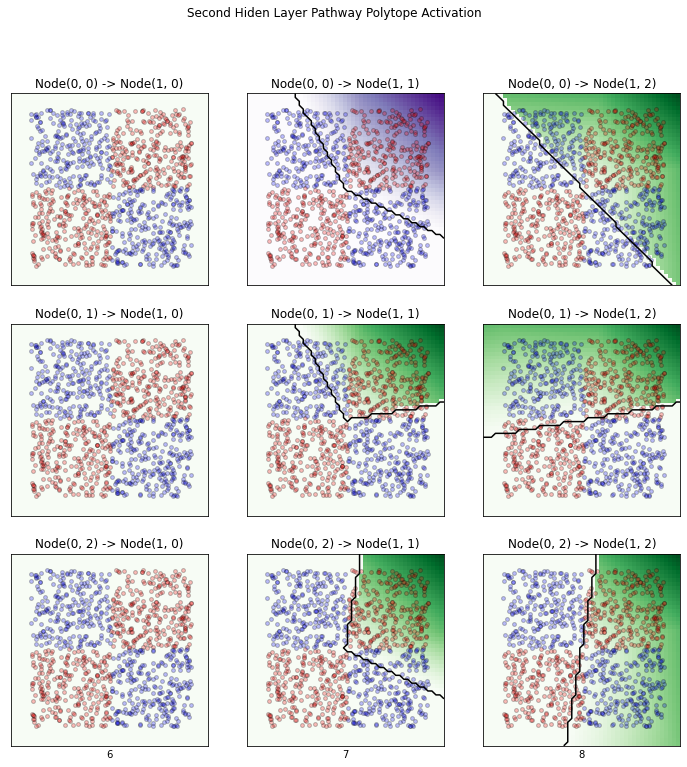

In [14]:
figs, axs = plt.subplots(width, width, figsize = (4 * width, 4 * width))

for i, ax in enumerate(axs.flat):
  ax.set(xlabel=i)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.label_outer()

figs.suptitle("Second Hiden Layer Pathway Polytope Activation")

encoders = [keras.models.Model(network.inputs, network.layers[i].output) for i in {0, 1}]

x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))


activations = np.array([encoder.predict(np.c_[xx.ravel(), yy.ravel()]) for encoder in encoders])
for penultimate_node in range(width):
  for second_node in range(width):
    penultimate_polytope_membership = activations[1, :, penultimate_node].reshape(xx.shape)
    second_polytope_membership = ((activations[0, :, second_node].reshape(xx.shape)) > 0).astype('int')
    polytope_membership = np.multiply(penultimate_polytope_membership, second_polytope_membership)
    w = ultimate_weights[penultimate_node] * np.array(ws[1])[second_node, penultimate_node]
    v = max(abs(np.min(polytope_membership)), abs(np.max(polytope_membership)))
    penultimate_heatmap = axs[second_node][penultimate_node].pcolormesh(xx, 
                                                   yy, 
                                                   polytope_membership, 
                                                   cmap="Greens" if w > 0 else "Purples", 
                                                   vmin = -v if np.min(polytope_membership) < 0 else 0, 
                                                   vmax = v if np.max(polytope_membership) > 0 else 0
                                                   )
    axs[second_node][penultimate_node].contour(xx, yy, polytope_membership, levels=[0], cmap="Greys_r")
    axs[second_node][penultimate_node].set_title("Node(0, {}) -> Node(1, {})".format(second_node, penultimate_node))

# Plot the training points
for y_val in range(2):
  idx = np.where(y == y_val)
  for penultimate_node in range(width):
    for second_node in range(width):
      pass
      axs[second_node][penultimate_node].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
                  cmap="Reds", s=15, alpha = 0.25, edgecolor = 'black')

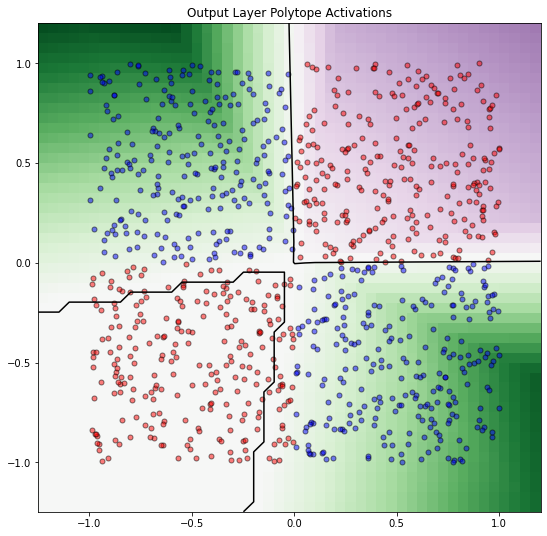

In [15]:
final_polytope = (np.matmul(activations[1], ultimate_weights)).reshape(xx.shape)

v = max(abs(np.min(final_polytope)), abs(np.max(final_polytope)))

fig = plt.figure(figsize=(9, 9))

#epsilon = 2e-1 * int(1 if ultimate_bias > 0 else -1)
final_heatmap = plt.pcolormesh(xx, 
                               yy, 
                               final_polytope, 
                               cmap="PRGn", 
                               vmin = -v, 
                               vmax = v)
#plt.contour(xx, yy, final_polytope + epsilon, levels=[0], cmap="Greys_r")
plt.contour(xx, yy, final_polytope, levels=[0], cmap="Greys_r")

#plt.title("Output Layer Polytope Activations\nBias={:0.2f}".format(float(ultimate_bias)))
plt.title("Output Layer Polytope Activations")

# Plot the training points
for y_val in range(2):
  idx = np.where(y == y_val)
  plt.scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
              cmap="Reds", s=25, alpha = 0.5, edgecolor = 'black')